<a href="https://colab.research.google.com/github/valentinabitonte/Esercizi/blob/main/Yelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd


In [4]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/yelp_labelled.txt


yelp_ds = pd.read_csv('yelp_labelled.txt', sep ='\t', header = None, names = ['reviews', 'sentiment'])


--2022-04-08 08:29:51--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/yelp_labelled.txt
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.148.58
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.148.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61320 (60K) [text/plain]
Saving to: ‘yelp_labelled.txt.2’

yelp_labelled.txt.2 100%[===================>]  59.88K  --.-KB/s    in 0.09s   

2022-04-08 08:29:52 (689 KB/s) - ‘yelp_labelled.txt.2’ saved [61320/61320]



In [6]:
df = yelp_ds

In [7]:
df

,reviews,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [9]:
df['reviews'].to_list()

['Wow... Loved this place.',
 'Crust is not good.',
 'Not tasty and the texture was just nasty.',
 'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.',
 'The selection on the menu was great and so were the prices.',
 'Now I am getting angry and I want my damn pho.',
 "Honeslty it didn't taste THAT fresh.)",
 'The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.',
 'The fries were great too.',
 'A great touch.',
 'Service was very prompt.',
 'Would not go back.',
 'The cashier had no care what so ever on what I had to say it still ended up being wayyy overpriced.',
 'I tried the Cape Cod ravoli, chicken,with cranberry...mmmm!',
 'I was disgusted because I was pretty sure that was human hair.',
 'I was shocked because no signs indicate cash only.',
 'Highly recommended.',
 'Waitress was a little slow in service.',
 'This place is not worth your time, let alone Vegas.',
 'did not like at all.'

In [10]:
df['reviews'].isnull().sum()
df = df.dropna()

In [11]:
import re

def clean_special_patterns(text):
    """Remove special patterns - email, url, date etc."""
    html_regex = re.compile(r"<.*?>")
    email_regex = re.compile(r"[\w.-]+@[\w.-]+")
    url_regex = re.compile(r"(http|www)[^\s]+")
    date_regex = re.compile(r"[\d]{2,4}[ -/:]*[\d]{2,4}([ -/:]*[\d]{2,4})?") # a way to match date
    new_line = re.compile(r"/(\r\n)+|\r+|\n+|\t+/")
    number = re.compile(r"[\d+]")
    under = re.compile(r"[^a-zA-Z0-9:$-,%.?!]+")
    simbols = re.compile(r"[^\w\s/'/`]")
    spaces = re.compile(r"\s{2,}")
    remove_singlelett= re.compile(r"(^| ).( |$)")

    ## remove
    text = text.lower()
    text = number.sub(" ", text)
    text = html_regex.sub(" ", text)
    text = url_regex.sub(" ", text)
    text = email_regex.sub(" ", text)
    text = date_regex.sub(" ", text)
    text = new_line.sub(" ", text)
    text = under.sub(" ", text)
    text = simbols.sub(" ", text)
    text = spaces.sub(" ", text)
    text = text.replace("`", "'")
    text = remove_singlelett.sub("",text)
    return text

In [12]:
df["reviews"] = df["reviews"].apply(clean_special_patterns)
df

,reviews,sentiment
0,wow loved this place,1
1,crust is not good,0
2,not tasty and the texture was just nasty,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1
...,...,...
995,think food should have flavor and texture and ...,0
996,appetite instantly gone,0
997,overallwas not impressed and would not go back,0
998,the whole experience was underwhelming andthin...,0


##STOP WORD AND LEMM

In [13]:
## Spacy Custom Pipeline
import numpy as np
import multiprocessing as mp

import string
import spacy 
from sklearn.base import TransformerMixin, BaseEstimator


nlp = spacy.load("en_core_web_sm")

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 nlp = nlp,
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Punctuation removal
            2. Stop words removal
            3. Lemmatization

        nlp  - spacy model
        n_jobs - parallel jobs to run
        """
        self.nlp = nlp
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _remove_punct(self, doc):
        return (t for t in doc if t.text not in string.punctuation)

    def _remove_stop_words(self, doc):
        return (t for t in doc if not t.is_stop)

    def _lemmatize(self, doc):
        return ' '.join(t.lemma_ for t in doc)

    def _preprocess_text(self, text):
        doc = self.nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

In [14]:
#takes 2 min of processing
text_preprocess = TextPreprocessor(n_jobs=-1)._preprocess_text
#df["text"][0:10].apply(text_preprocess)
df["reviews"] = df["reviews"].apply(text_preprocess)
df

,reviews,sentiment
0,wow love place,1
1,crust good,0
2,tasty texture nasty,0
3,stop late bank holiday rick steve recommendati...,1
4,selection menu great price,1
...,...,...
995,think food flavor texture lack,0
996,appetite instantly go,0
997,overallwas impressed,0
998,experience underwhelme andthink ninja sushi time,0


##EDA

In [15]:
cleaned = ' '.join(df['reviews'].to_list())

(-0.5, 799.5, 399.5, -0.5)

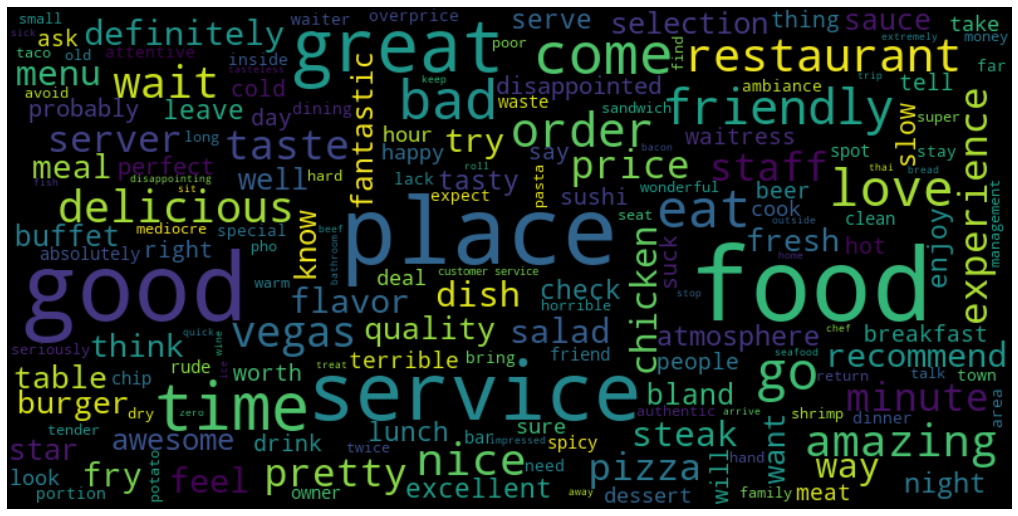

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 667)

wordcloud.generate(cleaned)

plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

##BAG OF WORD

In [17]:
X = df['reviews'] # FEATURES
y = df['sentiment'] # TARGET

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)

X_ = vectorizer.fit_transform(X).toarray()
X_

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

##TF-IDF

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer()
X_ = tfidfconverter.fit_transform(X_).toarray()
X_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [21]:
labels = ['NOT GOOD', 'GOOD']

##RANDOM FOREST

In [22]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=1000, random_state=667,max_depth=5)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=667)

In [23]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_pred, y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.724


Text(69.0, 0.5, 'Actual')

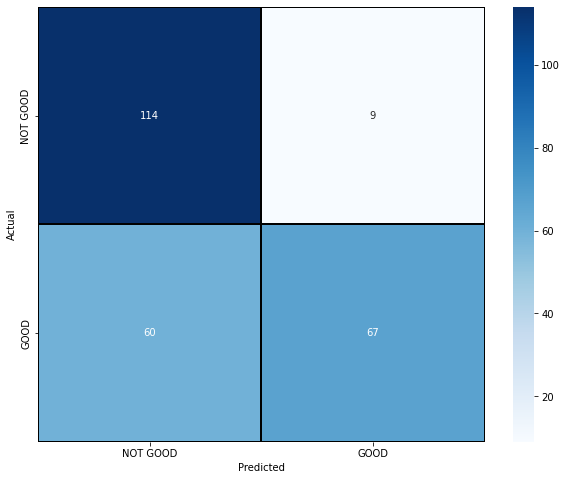

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [25]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    NOT GOOD       0.66      0.93      0.77       123
        GOOD       0.88      0.53      0.66       127

    accuracy                           0.72       250
   macro avg       0.77      0.73      0.71       250
weighted avg       0.77      0.72      0.71       250



In [26]:
!pip install plot-metric --quiet

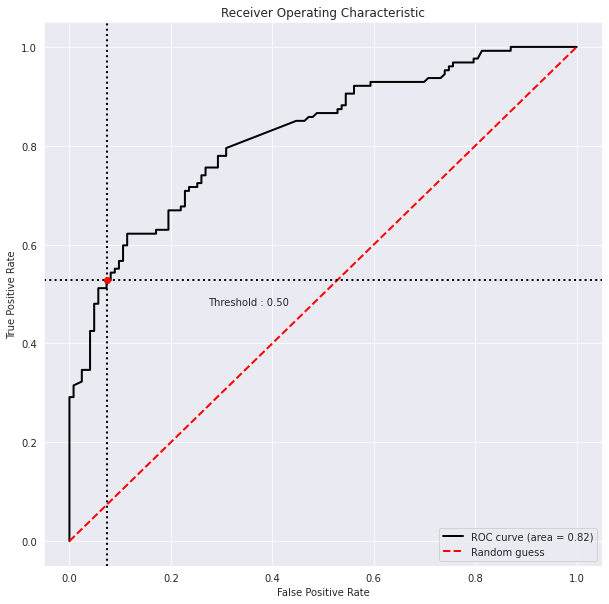

In [27]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

##Multinomial NB

In [28]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

In [29]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_pred, y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.732


Text(69.0, 0.5, 'Actual')

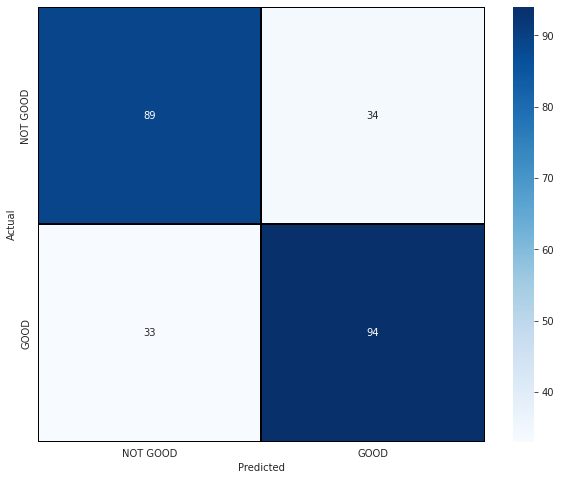

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [31]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    NOT GOOD       0.73      0.72      0.73       123
        GOOD       0.73      0.74      0.74       127

    accuracy                           0.73       250
   macro avg       0.73      0.73      0.73       250
weighted avg       0.73      0.73      0.73       250



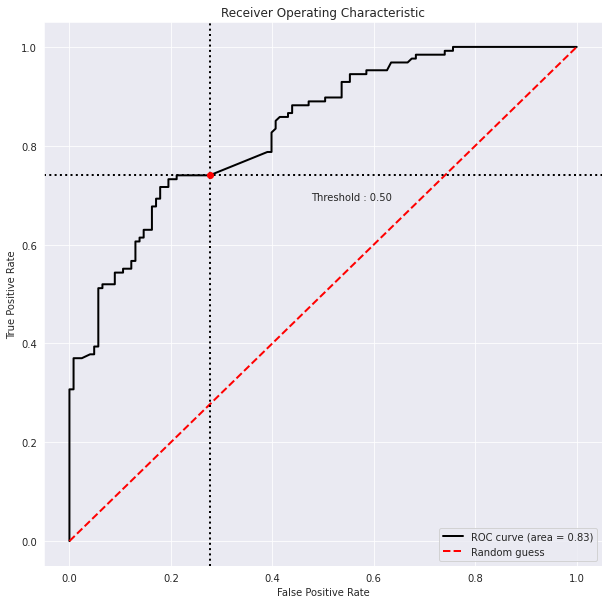

In [32]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

##SGD classifier

In [33]:
# accuracy score on the test data
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=667, max_iter=5, tol=None)
classifier.fit(X_train, y_train) 

y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_pred, y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.76


Text(69.0, 0.5, 'Actual')

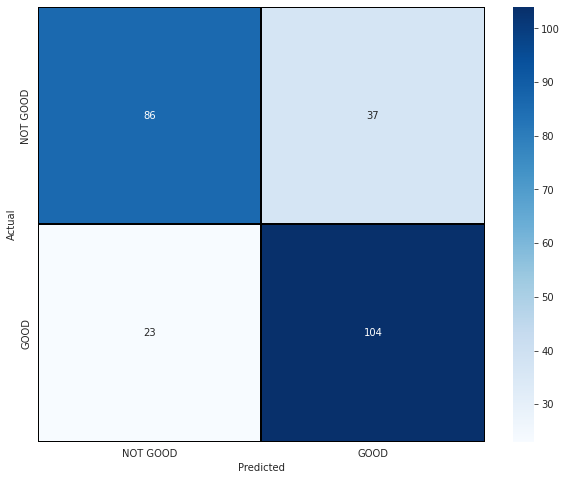

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [35]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    NOT GOOD       0.79      0.70      0.74       123
        GOOD       0.74      0.82      0.78       127

    accuracy                           0.76       250
   macro avg       0.76      0.76      0.76       250
weighted avg       0.76      0.76      0.76       250



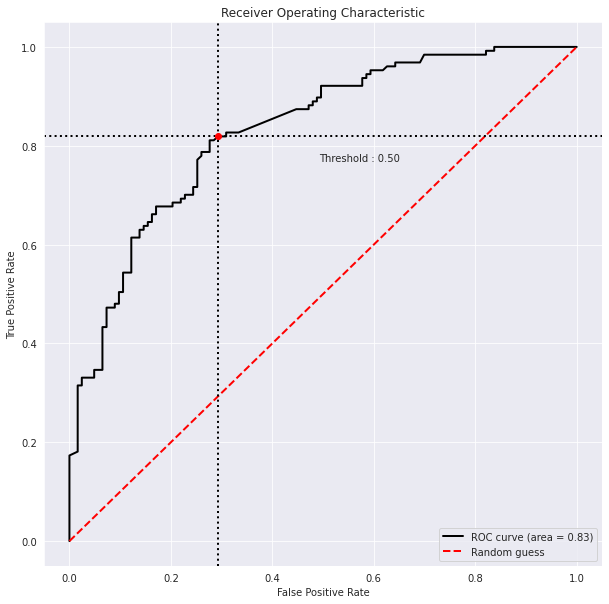

In [36]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

##PIPELINE

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [44]:
from sklearn.pipeline import Pipeline

text_preprocess = TextPreprocessor(n_jobs=-1)
bow = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
tfidf = TfidfTransformer()
classifier = SGDClassifier()

pipe = Pipeline([
                ('lemma_stop_rem',text_preprocess),
                ('bow',bow),
                ('tfidf',tfidf),
                ('clf',classifier),
                ])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)
test_data_accuracy = accuracy_score( y_test, predicted)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.676


In [42]:
test = pd.Series({'reviews':'good food'})

In [43]:
prediction = pipe.predict(test)
print(prediction[0])

if (prediction[0] == 0):
  print('Not good')
else:
  print('Good')

1
Good
